In [1]:
# imports
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
# define date parser
d_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# read csv file (set date column as index)
df = pd.read_csv(
    './data/energy-charts_Stromproduktion_und_Börsenstrompreise_in_Deutschland_2020_Excel.csv',
    delimiter=';', parse_dates=['Datum (MT+1)'], date_parser=d_parser
    # index_col='Datum (MT+1)'
)

In [3]:
# copy df to edit df
energy_df = df.copy()

# rename date column
energy_df.rename(columns={'Datum (MT+1)': 'Datetime', 'Day Ahead Auktion (DE-LU)': 'Energy_price', 'Nicht Erneuerbar': 'Nicht_Erneuerbar' }, inplace=True)

In [4]:
# add Date column
energy_df['Date'] = energy_df['Datetime'].dt.date

In [5]:
# add weekday column
energy_df['Day_of_week'] = energy_df['Datetime'].dt.day_name()

In [6]:
# remove import saldo column, as all values are NaN
energy_df = energy_df.dropna(axis=1, how="all")

In [7]:
# Check if there is any na value in df
energy_df.replace('na', np.nan, inplace=True)
energy_df.replace('NA', np.nan, inplace=True)
energy_df.replace('Missing', np.nan, inplace=True)
print(energy_df.isna().value_counts())

Datetime  Kernenergie  Nicht_Erneuerbar  Erneuerbar  Energy_price  Date   Day_of_week
False     False        False             False       False         False  False          35136
dtype: int64


In [8]:
# drop duplicates
energy_df.drop_duplicates(inplace=True)

In [9]:
# set Date column as index
energy_df.set_index('Datetime', inplace=True)

In [10]:
energy_df.head(10)

,Kernenergie,Nicht_Erneuerbar,Erneuerbar,Energy_price,Date,Day_of_week
Datetime,,,,,,
2020-01-01 00:00:00,8089.585,29700.989,14524.769,38.60,2020-01-01,Wednesday
2020-01-01 00:15:00,8087.935,29597.398,14407.463,38.60,2020-01-01,Wednesday
2020-01-01 00:30:00,8088.635,29433.049,14537.378,38.60,2020-01-01,Wednesday
2020-01-01 00:45:00,8086.715,29319.558,14695.598,38.60,2020-01-01,Wednesday
2020-01-01 01:00:00,8093.394,29202.803,14902.589,36.55,2020-01-01,Wednesday
2020-01-01 01:15:00,8090.135,29144.575,14898.388,36.55,2020-01-01,Wednesday
2020-01-01 01:30:00,8076.207,29123.509,14975.325,36.55,2020-01-01,Wednesday
2020-01-01 01:45:00,8064.899,29243.764,15021.521,36.55,2020-01-01,Wednesday
2020-01-01 02:00:00,8080.356,29402.351,15004.099,32.32,2020-01-01,Wednesday


In [11]:
energy_df.describe()

,Kernenergie,Nicht_Erneuerbar,Erneuerbar,Energy_price
count,35136.000000,35136.000000,35136.000000,35136.000000
mean,6934.673246,33765.069651,27962.757734,30.471738
std,969.703507,11159.545300,12106.069379,17.501029
min,3739.551000,11985.471000,7809.697000,-83.940000
25%,6450.204500,25593.516000,18140.908750,21.750000
50%,6793.422000,32771.112000,26610.473500,30.990000
75%,7834.915000,39948.887250,36752.224000,40.250000
max,8185.779000,68966.183000,69026.970000,200.040000


#### what does it mean when the price is minus?

>Negative Strompreise (oder sehr niedrige Strompreise) kommen im Großhandel dann vor, wenn ein Stromüberschuss besteht. Oder anders gesagt, wenn die Stromerzeugung den Stromverbrauch überschreitet. Eine solche Situation entsteht unter anderem, bei einer sehr hohen Einspeisung mit sehr preisgünstigem Strom aus Wind, wie das im Moment der Fall ist.
[agrarheute](https://www.agrarheute.com/markt/diesel/strompreise-fallen-neue-tiefstaende-stromkunden-gehen-leer-602385)

In [12]:
energy_df.loc[:,['Kernenergie', 'Nicht_Erneuerbar', 'Erneuerbar', 'Energy_price']].corr()

,Kernenergie,Nicht_Erneuerbar,Erneuerbar,Energy_price
Kernenergie,1.000000,0.407680,-0.135737,0.372776
Nicht_Erneuerbar,0.407680,1.000000,-0.459684,0.796859
Erneuerbar,-0.135737,-0.459684,1.000000,-0.512600
Energy_price,0.372776,0.796859,-0.512600,1.000000


### Analization - Day_of_week and Energy Price

In [13]:
# Name dataframe grouped by weekeday
grp_day_of_week = energy_df.groupby(['Day_of_week'])

In [14]:
monday = grp_day_of_week.get_group('Monday')
monday

,Kernenergie,Nicht_Erneuerbar,Erneuerbar,Energy_price,Date,Day_of_week
Datetime,,,,,,
2020-01-06 00:00:00,7747.079,32613.952,25506.327,29.00,2020-01-06,Monday
2020-01-06 00:15:00,7765.926,32690.316,25194.688,29.00,2020-01-06,Monday
2020-01-06 00:30:00,7763.077,32732.358,25048.000,29.00,2020-01-06,Monday
2020-01-06 00:45:00,7745.940,32552.516,24946.564,29.00,2020-01-06,Monday
2020-01-06 01:00:00,7768.946,32700.959,24905.467,29.08,2020-01-06,Monday
...,...,...,...,...,...,...
2020-12-28 22:45:00,8132.878,32297.707,14213.323,42.14,2020-12-28,Monday
2020-12-28 23:00:00,8135.377,30775.400,14230.425,38.80,2020-12-28,Monday
2020-12-28 23:15:00,8135.977,30408.404,14212.882,38.80,2020-12-28,Monday


In [15]:
list_day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
list_df_day_of_week = []

# create a data frame sorted by Day_of_week
for day in list_day_of_week:
    df_name = day.lower()
    df_name = grp_day_of_week.get_group(day)
    list_df_day_of_week.append(df_name)

# after for loop, we should have a dataframe like below for each Day_of_week.
# monday = grp_day_of_week.get_group('Monday')
monday

,Kernenergie,Nicht_Erneuerbar,Erneuerbar,Energy_price,Date,Day_of_week
Datetime,,,,,,
2020-01-06 00:00:00,7747.079,32613.952,25506.327,29.00,2020-01-06,Monday
2020-01-06 00:15:00,7765.926,32690.316,25194.688,29.00,2020-01-06,Monday
2020-01-06 00:30:00,7763.077,32732.358,25048.000,29.00,2020-01-06,Monday
2020-01-06 00:45:00,7745.940,32552.516,24946.564,29.00,2020-01-06,Monday
2020-01-06 01:00:00,7768.946,32700.959,24905.467,29.08,2020-01-06,Monday
...,...,...,...,...,...,...
2020-12-28 22:45:00,8132.878,32297.707,14213.323,42.14,2020-12-28,Monday
2020-12-28 23:00:00,8135.377,30775.400,14230.425,38.80,2020-12-28,Monday
2020-12-28 23:15:00,8135.977,30408.404,14212.882,38.80,2020-12-28,Monday


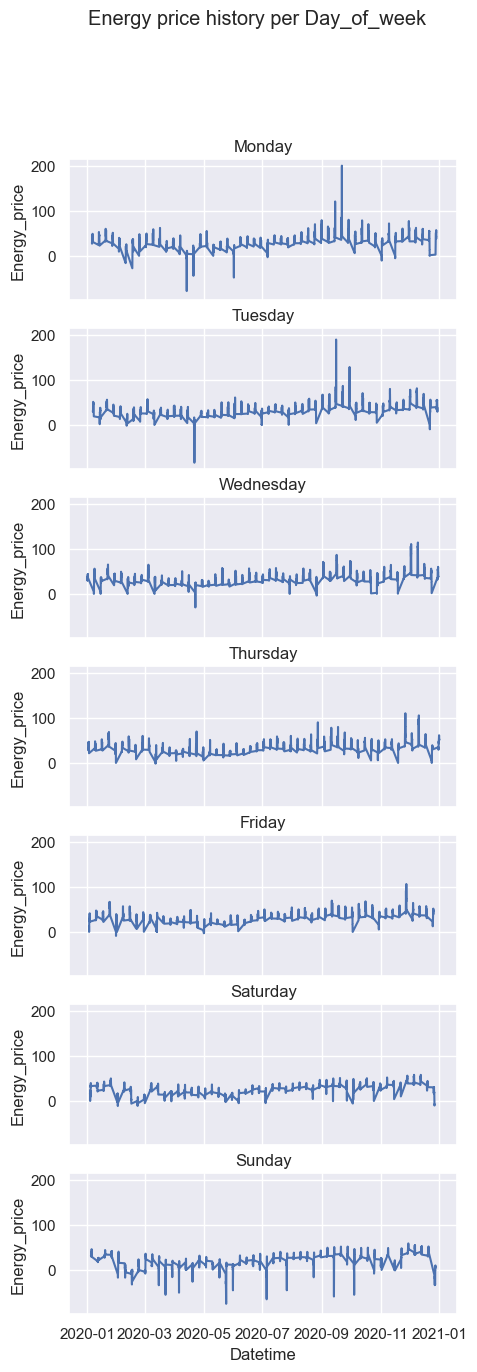

In [16]:
# set seaborn plotting aesthetics as default
sns.set()
# define plotting region (1 row, 7 columns)
fig, axes = plt.subplots(7, 1, sharex=True, sharey=True, figsize=(5, 15))
fig.suptitle('Energy price history per Day_of_week')

for i, (day_name, df) in enumerate(zip(list_day_of_week, list_df_day_of_week)):
    sns.lineplot(x=df.index, y='Energy_price', data=df, ax=axes[i])
    axes[i].set_title(day_name)
    
plt.show()

<AxesSubplot: xlabel='Datetime', ylabel='Energy_price'>

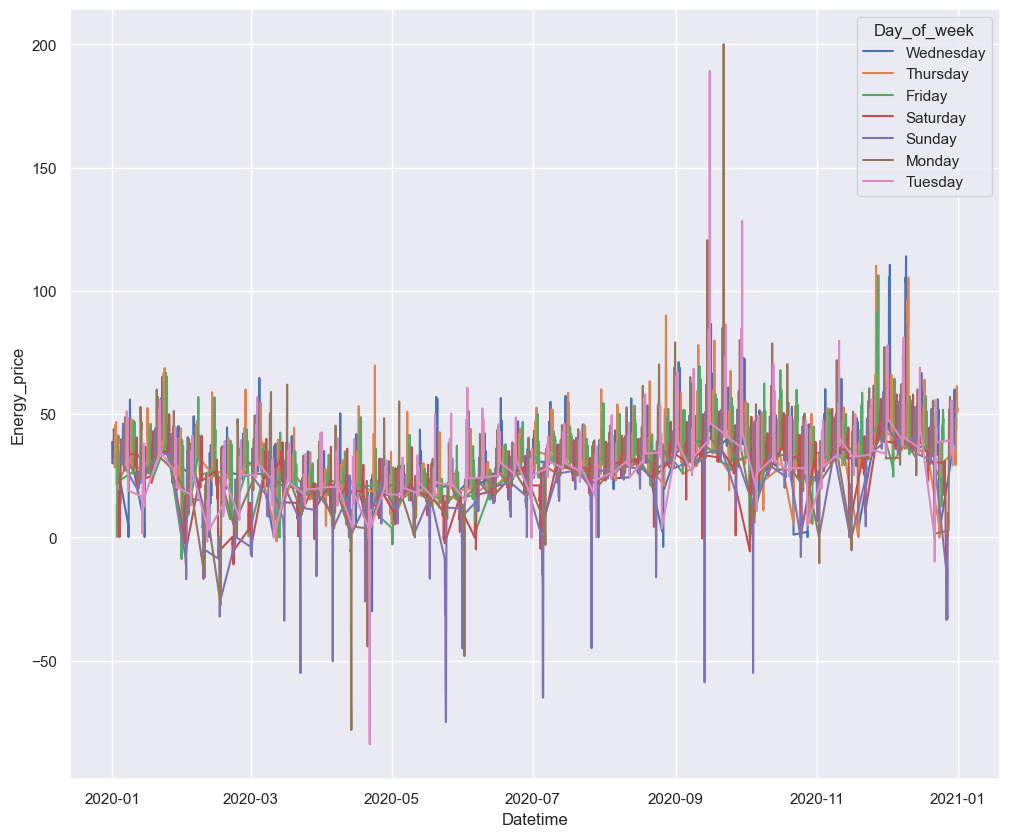

In [17]:
# plot the data
# set figure size
rcParams['figure.figsize'] = 12,10
sns.lineplot(
    x=energy_df.index, 
    y='Energy_price',
    data=energy_df,
    hue='Day_of_week'
    )

In [18]:
# Energy price grouped by Day_of_week
desc = grp_day_of_week['Energy_price'].describe()
# Add a column Q3 - Q1
desc['QD'] = (desc['75%'] - desc['25%']) / 2
# create a series of median and rename column
median = grp_day_of_week['Energy_price'].median()
median.rename('median', inplace=True)

# merge extended description and median 
desc_with_med_and_qd = pd.merge(desc, median, on='Day_of_week')
desc_with_med_and_qd.reindex(index=list_day_of_week)

,count,mean,std,min,25%,50%,75%,max,QD,median
Day_of_week,,,,,,,,,,
Monday,4992.0,32.391106,18.979678,-78.15,22.6125,33.365,43.2925,200.04,10.34000,33.365
Tuesday,4992.0,33.767548,18.152121,-83.94,24.2775,33.000,42.4600,189.25,9.09125,33.000
Wednesday,5088.0,35.137555,15.999207,-29.98,25.5375,33.785,43.2300,114.00,8.84625,33.785
Thursday,5088.0,35.097586,14.358696,-1.58,25.7650,34.040,43.1850,110.13,8.71000,34.040
Friday,4992.0,33.382268,13.440421,-8.77,24.9200,33.595,41.2525,106.35,8.16625,33.595
Saturday,4992.0,25.210457,12.838657,-11.16,17.1250,26.260,34.0000,58.00,8.43750,26.260
Sunday,4992.0,18.136963,20.075361,-74.97,7.5700,21.445,32.0100,58.97,12.22000,21.445


- Energy price on weekend are lower than on weekdays
- Mean and median are almost the same -> the prices are more or less evenly distributed from the lowest to highest price
- Standard deviation and Q3 - Q1 for this case??

<AxesSubplot: xlabel='Day_of_week', ylabel='Energy_price'>

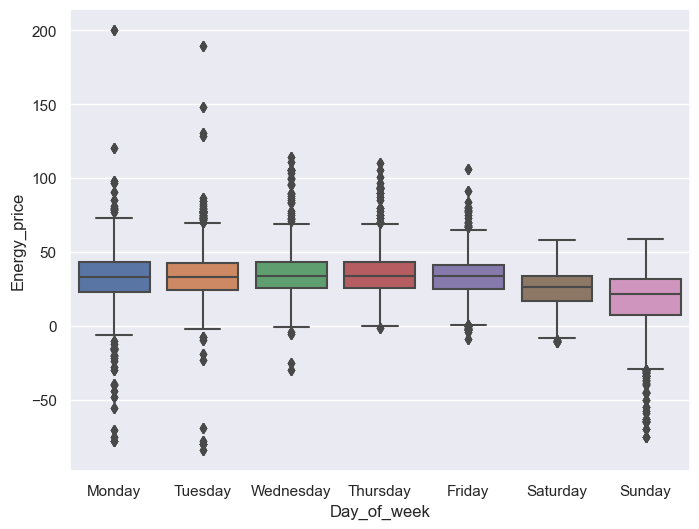

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x=energy_df['Day_of_week'], 
    order=list_day_of_week, 
    y=energy_df['Energy_price'] 
    )

- Monday and Tuesday have more outliers compared to the other weekdays -> Prediction for Monday and Tuesday would be more difficult than for other week days.
- Sunday has also relatively many outliers, but they are all lower than the average value
- Weekdays don't seem to have a crutial influence on the energy price.
- Energy price tends to decrease slightly on weekends.
- Energy price on Saturday seem to be most stable.

>Die Preisunterschiede an einem Tag sind unter der Woche stärker ausgeprägt als am Wochenende (einschließlich Feiertage). Von Montag bis Freitag liegen Höchst- und Tiefstpreise stärker auseinander als an Samstagen und Sonntagen. Der Grund dafür ist, dass viele Berufstätige am Wochenende nicht arbeiten und die Kinder zuhause sind. Wann dann etwa jede Familie morgens Kaffee oder Tee kocht, verteilt sich stärker über den Vormittag – an Wochentagen konzentriert sich das auf weniger Stunden am Morgen.
["Wann Du Strom verbrauchst, ist entscheidend für seinen Preis" - finanztip.de](https://www.finanztip.de/stromtarife/variable-stromtarife/)

## Exponential Smoothing

#### Holt-Winters model
- has Trend
- has Seasonality
- Not random

In [20]:
# Exponential smoothing
sr_exp_smoothing = energy_df.copy()
# resample the data - take day as unit(use mean value)
sr_exp_smoothing = sr_exp_smoothing['Energy_price'].resample(rule='D').mean()

<AxesSubplot: xlabel='Datetime'>

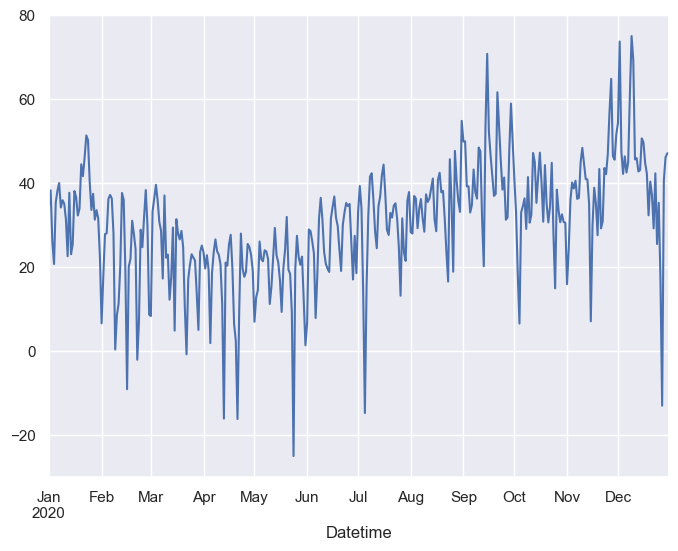

In [21]:
# set figure size
rcParams['figure.figsize'] = 8,6
# plot
sr_exp_smoothing.plot()

In [22]:
# Build a model
model = ExponentialSmoothing(endog=sr_exp_smoothing).fit()

In [23]:
# create prediction for 60 days
predictions = model.forecast(60)

<AxesSubplot: xlabel='Datetime'>

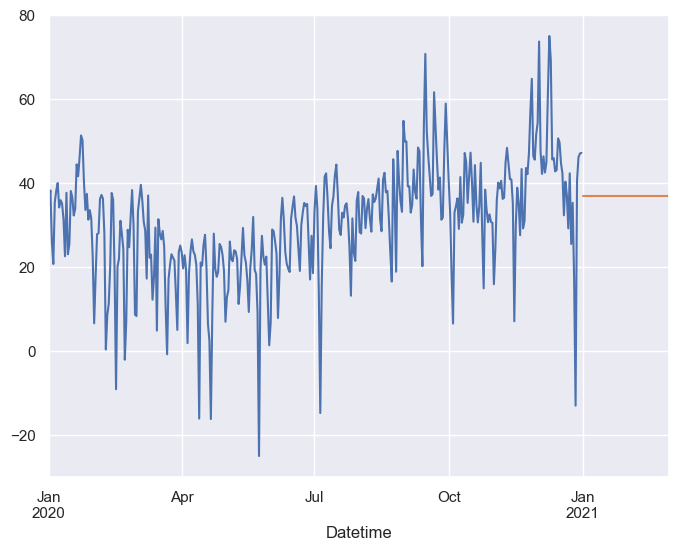

In [24]:
# set figure size
sr_exp_smoothing.plot(figsize = (8, 6))
# Plot predictions
predictions.plot()

### Regression with Formula API

In [29]:
import statsmodels.formula.api as smf

In [34]:
model = smf.ols(data=energy_df,
        formula = 'Energy_price ~ Erneuerbar + Nicht_Erneuerbar + Kernenergie'
        )
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Energy_price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                 2.336e+04
Date:                Tue, 31 Jan 2023   Prob (F-statistic):               0.00
Time:                        22:55:35   Log-Likelihood:            -1.3115e+05
No. Observations:               35136   AIC:                         2.623e+05
Df Residuals:                   35132   BIC:                         2.623e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -6.5873      0.439    -14.994      0.000      -7.448      -5.726
Erneuerbar          -0.0003   5.03e-06    -54.631      0.000      -0.000      -0.000
Nicht_Erneuerbar     0.0011   5.92e-06    180.513      0.000       0.001       0.001
Kernenergie          0.0012   6.11e-05     20.466      0.000       0.001       0.001
==============================================================================
Omnibus:                     8612.165   Durbin-Watson:                   0.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           597676.538
Skew:                          -0.079   Prob(JB):                         0.00
Kurtosis:                      23.205   Cond. No.                     3.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""